In [1]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.visualization import plot_histogram
from qiskit.circuit import Gate

3.8.1 (tags/v3.8.1:1b293b6006, Jan  6 2020, 11:40:25) 
[GCC 9.2.1 20191008]


/usr/local/lib/python3.8/site-packages/websockets/framing.py:76: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def read(cls, reader, *, mask, max_size=None, extensions=None):
/usr/local/lib/python3.8/site-packages/websockets/http.py:53: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def read_request(stream):
/usr/local/lib/python3.8/site-packages/websockets/http.py:98: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def read_response(stream):
/usr/local/lib/python3.8/site-packages/websockets/http.py:142: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def read_headers(stream):
/usr/local/lib/python3.8/site-packages/websockets/http.py:182: DeprecationWarning: "@coroutine" decorator is deprecated since Python 3.8, use "async def" instead
  def read_line(stream):
/usr/local/lib

In [3]:
# example of a ccx/toffoli gate

amount_of_qbits = 3

# build the main circuit
circuit = QuantumCircuit(amount_of_qbits)

# circuit.toffoli(2,1,0)
circuit.ccx(0,1,2)

# Draw the circuit
circuit.draw(output="mpl")
circuit.draw(output="text")

q_0: ──■──
       │  
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘

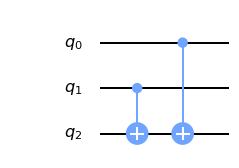

In [7]:
# example of 2 cnot gates

amount_of_qbits = 3

# build the main circuit
circuit = QuantumCircuit(amount_of_qbits)

circuit.cx(1,2)
circuit.cx(0,2)

# Draw the circuit
circuit.draw(output="mpl")

input : 000
output: 000


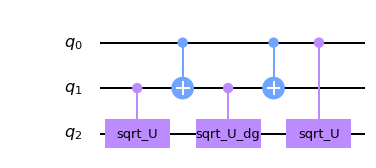

In [46]:
def outputstate_to_bin(outputstate):
    # get amount of bits
    l = np.log2(len(outputstate))
    # find every index where there is a non-zero probability
    #indexes = np.where(res != 0)[0]
    indexes = np.where(outputstate)[0]
    # convert it to bin
    s = [bin(i)[2:] for i in indexes]
    # pad with zeros
    s = [
        '0'*int(l-len(i)) + i
        for i in s
    ]
    # move lowest bit to the right
    s = [i[::-1] for i in s]
    # return all the results
    return ' & '.join(s)

def get_results(circuit):
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(circuit, simulator)
    result = job.result()
    outputstate = result.get_statevector(circuit, decimals=3)
    return outputstate_to_bin(outputstate)

def create_toffoli_gate(i2=0, i1=0, i0=0, sqrt=False):
    amount_of_qbits = 3
    circuit = QuantumCircuit(amount_of_qbits)
    
    if i0:
        circuit.x(0)
    if i1:
        circuit.x(1)
    if i2:
        circuit.x(2)

    if sqrt:
        circuit.append(sqrt_x.control(), [1,2])
        circuit.cx(0,1)
        circuit.append(sqrt_x.inverse().control(), [1,2])
        circuit.cx(0,1)
        circuit.append(sqrt_x.control(), [0,2])
    else:
        circuit.cx(1,2)
        circuit.cx(0,1)
        circuit.cx(1,2)
        circuit.cx(0,1)
        circuit.cx(0,2)
    
    print(f"input : {i0}{i1}{i2}")
    print(f"output: {get_results(circuit)}")
    return circuit.draw(output="mpl")

# for i0 in (0,1):
#     for i1 in (0,1):
#         for i2 in (0,1):
#             create_toffoli_gate(i2, i1, i0, False)
create_toffoli_gate(0,0,0, True)

In [45]:
sqrt_x.name = "sqrt_U"

000


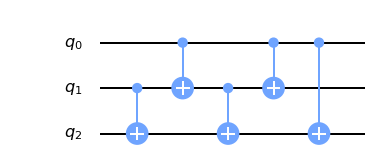

In [8]:
# Superdense Coding Circuit using a bell pair

amount_of_qbits = 3

# build the main circuit
circuit = QuantumCircuit(amount_of_qbits)

circuit.cx(1,2)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.cx(0,1)
circuit.cx(0,2)

simulator = Aer.get_backend('statevector_simulator')
job = execute(circuit, simulator)
result = job.result()
outputstate = result.get_statevector(circuit, decimals=3)
print(outputstate_to_bin(outputstate))

# Draw the circuit
circuit.draw(output="mpl")

In [108]:
# a helper class for defining quantum circuits

class GateWrapper(object):
    amount_of_qbits = 3
    amount_of_cbits = 1
    display_gate = False
    
    def draw(self, output="mpl"):
        # if the circuit is not initialized
        if getattr(self, "circuit", None) is None:
            # then initialize it
            self.execute()

        return self.circuit.draw(output=output)
    
    def prepare_initial_state(self, initial_state):
        # the initial state of a quantum register is |0>
        # thus, to get the |1> state, a X gate is applied
        for i in range(len(initial_state)):
            if initial_state[i] == '1':
                self.circuit.x(i)
    
    def logic(self):
        raise NotImplementedError()
    # in a basic case, self.logic is enough
    # in the BernsteinVazirani, for example, it is nice to split it into several functions
    def pre_logic(self):
        pass
    def post_logic(self):
        pass
    def measure(self):
        pass


    # helper function
    def get_output_state(self):
        simulator = Aer.get_backend('statevector_simulator')
        job = execute(self.circuit, simulator)
        result = job.result()
        outputstate = result.get_statevector(self.circuit, decimals=3)    

        return outputstate

    # helper function
    @staticmethod
    def outputstate_to_bin(outputstate):
        # get amount of bits
        l = np.log2(len(outputstate))
        # find every index where there is a non-zero probability
        #indexes = np.where(res != 0)[0]
        indexes = np.where(outputstate)[0]
        # convert it to bin
        s = [bin(i)[2:] for i in indexes]
        # pad with zeros
        s = [
            '0'*int(l-len(i)) + i
            for i in s
        ]
        # move lowest bit to the right
        s = [i[::-1] for i in s]
        # return all the results
        return ' & '.join(s)

    def initialize_circuit(self):
        self.circuit = QuantumCircuit(self.amount_of_qbits, self.amount_of_cbits)
        
    def execute(self, state="0", raw=False):
        self.initialize_circuit()
        self.prepare_initial_state(state)
        
        self.pre_logic()
        self.logic()
        self.post_logic()
        self.measure()
        
        if self.display_gate:
            self.print()
        
        outputstate = self.get_output_state()
        if raw:
            return outputstate
        else:
            return self.outputstate_to_bin( outputstate )

    def execute_all(self):
        results = []
        for i in range(2**self.amount_of_qbits):
            s = bin(i)[2:].zfill(self.amount_of_qbits)
            o = self.execute(s)
            results.append((s, o))
            print(f"{s} -> {o}")

In [109]:
class Toffoli(GateWrapper):
    input_state = "000"
    def pre_logic(self):
        for i in range(len(self.input_state)):
            if self.input_state[i] == '1':
                self.circuit.x(i)

    def logic(self):
        self.circuit.cx(1,2)
        self.circuit.cx(1,0)
        self.circuit.cx(0,2)
        self.circuit.x(1)
        self.circuit.cx(1,2)
        return
        
        self.circuit.cx(1,2)
        self.circuit.cx(1,0)
        self.circuit.cx(0,2)
        self.circuit.cx(1,2)
        self.circuit.cx(1,0)
        self.circuit.cx(0,2)

        self.circuit.cx(1,0)
        self.circuit.cx(0,2)
        self.circuit.cx(1,0)
        self.circuit.cx(0,1)
        self.circuit.cx(1,0)
        
        self.circuit.cx(1,0)
        self.circuit.cx(0,1)
#         self.circuit.x(1)
#         self.circuit.cx(0,2)


000 -> 011
001 -> 010
010 -> 100
011 -> 101
100 -> 110
101 -> 111
110 -> 001
111 -> 000


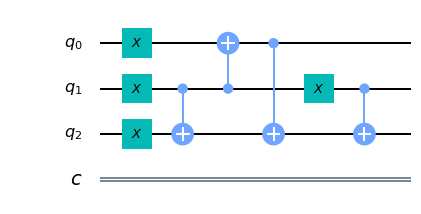

In [110]:
t = Toffoli()
t.execute_all()
t.draw()

In [111]:
Gate?

In [112]:
dir(circuit)

['AND',
 'OR',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_append',
 '_bind_parameter',
 '_bit_argument_conversion',
 '_check_cargs',
 '_check_compatible_regs',
 '_check_dup_param_spec',
 '_check_dups',
 '_check_qargs',
 '_create_creg',
 '_data',
 '_increment_instances',
 '_layout',
 '_parameter_table',
 '_rebind_definition',
 '_substitute_parameter',
 '_unroll_param_dict',
 '_update_parameter_table',
 'add_register',
 'append',
 'assign_parameters',
 'barrier',
 'bind_parameters',
 'cast',
 'cbit_argument_conversion',
 'ccx',
 'ch',
 'clbits',
 'cls_instances',
 'cls_prefix',
 'cnot',
 'combine',
 'compose',
 

In [119]:
c = QuantumCircuit(1)
temp = np.pi/2
# c.u3(temp, -temp, -3*temp, 0)
c.u2(-temp, temp, 0)
# c.draw()
simulator = Aer.get_backend('statevector_simulator')
job = execute(c, simulator)
result = job.result()
outputstate = result.get_statevector(c, decimals=3)
outputstate

array([1.+0.j, 0.+0.j])

In [120]:
c = QuantumCircuit(1, name="Sqrt_X")
c.u2(-np.pi/2, np.pi/2, 0)
sqrt_x = c.to_gate()
sqrt_x

In [134]:
c2 = QuantumCircuit(1)
c2.append(sqrt_x, [0])
c2.append(sqrt_x, [0])
c2.append(sqrt_x, [0])
c2.append(sqrt_x, [0])
# c2.x(0)
c2.draw()

simulator = Aer.get_backend('statevector_simulator')
job = execute(c2, simulator)
result = job.result()
outputstate = result.get_statevector(c2, decimals=3)
outputstate

array([1.+0.j, 0.+0.j])

In [25]:
# There is an option to create a gate out of a circuit.
# In the following case it is not necessary, though I used it for educational purposes.

# Let us create a Sqrt_X gate
def create_sqrt_x():
    c = QuantumCircuit(1, name="Sqrt_X") # this gate operates on 1 qbit
    # apply the relevant logic.
    c.u2( # more about u2 later.
        phi=-np.pi/2,
        lam=np.pi/2,
        qubit=0
    )
    # save this circuit as a gate
    return c.to_gate()

sqrt_x = create_sqrt_x()

# About u2.
# There are 3 u-gates. u1, u2, u3.
# Their implementation can be found at:
# https://github.com/Qiskit/qiskit-terra/tree/master/qiskit/circuit/library/standard_gates
# Further details can be found here:
# https://quantum-computing.ibm.com/docs/iqx/q-gates#u2-gate
# https://qiskit.org/documentation/stubs/qiskit.circuit.library.U2Gate.html
#
# Their example tells us that: U2(-\pi/2, \pi/2) = RX(\pi/2)
# This would translate to:
# RZ(-pi/2).RY(pi/2).RZ(pi/2)
# In other words, it would 

# using sqrt_x
def create_circuit():
    c = QuantumCircuit(1)
    # append our gate, with a list of qbits to operate on.
    # the length of the list has to equal sqrt_x.num_qubits.
    c.append(sqrt_x, [0])
    c.draw()
    return c

def get_result(circuit):
    simulator = Aer.get_backend('statevector_simulator')
    job = execute(circuit, simulator)
    result = job.result()
    outputstate = result.get_statevector(circuit, decimals=3)
    return outputstate

In [133]:
c.u2?


In [30]:
sqrt_x.inverse().control()